In [1]:
from jax_circuits import *
# from exact_decompositions import *
from qiskit import transpile
from qiskit.circuit.library import *
from qiskit.quantum_info import OneQubitEulerDecomposer, random_clifford
from cp_utils import *
from scipy.stats import unitary_group

To do

1. Local minima plots in an accurate way:
    1. For each ansatz several random unitaries and several self-unitaries. 
    1. Separately stats for different realizations of Toffoli 3 and Toffoli 4 gates.

# Local minimums

In [36]:
def success_ratio(num_qubits, num_cz_gates, target, u_target=None, num_samples=100):
    anz = Ansatz(num_qubits, 'cz', fill_layers(sequ_layer(num_qubits), num_cz_gates))
    
    if target == 'random_unitary':
        u_target = unitary_group.rvs(2**num_qubits, random_state=42)
    elif target == 'self':
        angles_target = random_angles(anz.num_angles, key=random.PRNGKey(42))
        u_target = anz.unitary(angles_target)
    
        
    results = anz.learn(u_target, num_repeats=num_samples)
    best_losses = [jnp.min(r['loss']) for r in results]
    
    if target == 'random_unitary':
        successes = [loss <= (min(best_losses)+1e-4) for loss in best_losses]
    elif target == 'self':
        successes = [loss < 1e-4 for loss in best_losses]
    
    return sum(successes)/len(successes)

def success_chart(num_qubits, num_cz_gates_list, target, save_to, u_target=None, num_samples=100):
    success_list = []
    for num_cz_gates in tqdm(num_cz_gates_list):
        success_list.append(success_ratio(num_qubits, num_cz_gates, target, num_samples=num_samples))
        
    with open(save_to, 'wb') as f:
        pickle.dump(success_list, f)
        
    return success_list

In [35]:
success_ratio(3, 6, 'self')

DeviceArray(0.1, dtype=float32)

In [20]:
success_chart(3, range(15)[::3], 'self', 'results/s_chart_3_self')

  0%|          | 0/5 [00:00<?, ?it/s]

[DeviceArray(1., dtype=float32),
 DeviceArray(0.78, dtype=float32),
 DeviceArray(0.1, dtype=float32),
 DeviceArray(0., dtype=float32),
 DeviceArray(0., dtype=float32)]

In [22]:
list(range(15)[::3])
                                                       
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    l''    
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

[0, 3, 6, 9, 12]

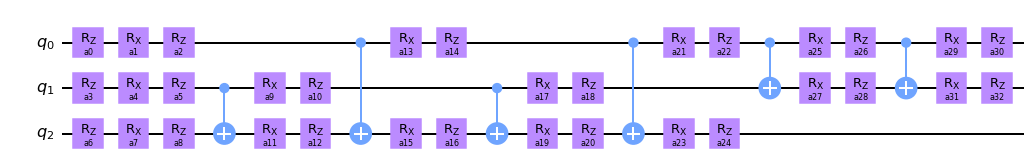

In [2]:
placements_toff3 = [[1, 2], [0, 2], [1, 2], [0, 2], [0, 1], [0, 1]]
anz = Ansatz(3, 'cx', placements={'free': placements_toff3})

anz.circuit().draw(output='mpl')

In [3]:
res = anz.learn(u_toff3, num_repeats=200)

In [4]:
s = [min(r['loss'])<1e-4 for r in res]
sum(s)/len(s)

0.535

In [5]:
results = Results.load('results/toff3_conn_test')
results.decompositions

[< toff3_conn_test| Approximate | cz count: 6 | cz depth: 6 | loss: 0.0 >,
 < toff3_conn_test| Approximate | cz count: 6 | cz depth: 6 | loss: 0.0 >,
 < toff3_conn_test| Approximate | cz count: 6 | cz depth: 6 | loss: 1.1920928955078125e-07 >,
 < toff3_conn_test| Approximate | cz count: 7 | cz depth: 7 | loss: 0.0 >,
 < toff3_conn_test| Approximate | cz count: 7 | cz depth: 7 | loss: 0.0 >,
 < toff3_conn_test| Approximate | cz count: 6 | cz depth: 6 | loss: 0.0 >,
 < toff3_conn_test| Approximate | cz count: 8 | cz depth: 8 | loss: 0.0 >,
 < toff3_conn_test| Approximate | cz count: 8 | cz depth: 8 | loss: 0.0 >,
 < toff3_conn_test| Approximate | cz count: 9 | cz depth: 9 | loss: 0.0 >]

In [6]:
n = 0

d = results.decompositions[n]
qc = d.circuit
u, angles, wires = qiskit_circ_to_jax_unitary(qc)

loss_f = lambda angs: disc2(u(angs), u_toff3)
res = mynimize_repeated(loss_f, len(angles), num_repeats=100)

s = [min(r['loss'])<1e-4 for r in res]
sum(s)/len(s)

0.36

In [7]:
n = 1

d = results.decompositions[n]
qc = d.circuit
u, angles, wires = qiskit_circ_to_jax_unitary(qc)

loss_f = lambda angs: disc2(u(angs), u_toff3)
res = mynimize_repeated(loss_f, len(angles), num_repeats=100)

s = [min(r['loss'])<1e-4 for r in res]
sum(s)/len(s)

0.68

In [9]:
n = 2

d = results.decompositions[n]
qc = d.circuit
u, angles, wires = qiskit_circ_to_jax_unitary(qc)

loss_f = lambda angs: disc2(u(angs), u_toff3)
res = mynimize_repeated(loss_f, len(angles), num_repeats=100)

s = [min(r['loss'])<1e-4 for r in res]
sum(s)/len(s)

0.52